In [28]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes (2).csv


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [30]:
df = pd.read_csv('diabetes.csv')
df

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [31]:
X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)
print("----------------------------------")
print(X_test_scaled)

[[-0.52639686 -1.15139792 -3.75268255 ... -4.13525578 -0.49073479
  -1.03594038]
 [ 1.58804586 -0.27664283  0.68034485 ... -0.48916881  2.41502991
   1.48710085]
 [-0.82846011  0.56687102 -1.2658623  ... -0.42452187  0.54916055
  -0.94893896]
 ...
 [ 1.8901091  -0.62029661  0.89659009 ...  1.76054443  1.981245
   0.44308379]
 [-1.13052335  0.62935353 -3.75268255 ...  1.34680407 -0.78487662
  -0.33992901]
 [-1.13052335  0.12949347  1.43720319 ... -1.22614383 -0.61552223
  -1.03594038]]
----------------------------------
[[ 0.68185612 -0.71402038 -0.61712658 ...  0.26073561 -0.11637247
   0.87809089]
 [-0.52639686 -0.27664283  0.30191569 ...  0.48053518 -0.954231
  -1.03594038]
 [-0.52639686 -0.40160784 -0.29275872 ... -0.15300476 -0.9245197
  -1.03594038]
 ...
 [ 1.28598261 -0.80774414  0.13973176 ...  0.62275843  0.04703966
   2.0961108 ]
 [-0.52639686  0.78555979  0.03160914 ... -0.51502758 -0.39268751
  -0.33992901]
 [ 1.28598261 -1.46381046  0.03160914 ...  0.42881763  0.70068816
  

In [18]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators':[100, 150, 200, 300],
    'learning_rate':[0.01, 0.1,0.15],
    'max_depth':[2, 3, 4, 5],
    'subsample':[0.8, 1.0],
    'colsample_bytree':[0.8, 1.0]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=skf,
                           verbose=1,
                           n_jobs=-1)

In [33]:
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Recall:", grid_search.best_score_)
y_pred = best_model.predict(X_test_scaled)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 300, 'subsample': 1.0}
Best Cross-Validated Recall: 0.6530454042081948


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [34]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[74 25]
 [19 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77        99
           1       0.59      0.65      0.62        55

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.72      0.71      0.72       154



In [35]:
best_model.feature_importances_

array([0.08652511, 0.26837045, 0.06181367, 0.10702729, 0.08559693,
       0.14995432, 0.07609095, 0.16462135], dtype=float32)

<Axes: xlabel='features', ylabel='Importances'>

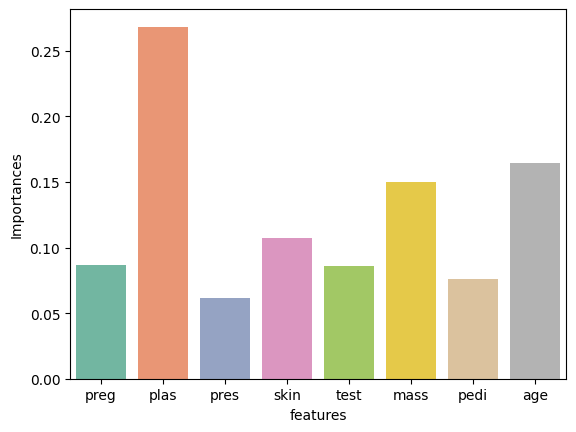

In [40]:
import seaborn as sns
import pandas as pd

importances = best_model.feature_importances_


df1 = pd.DataFrame({'features': features, 'Importances': importances})

sns.barplot(data=df1, x='features', y='Importances', hue='features', palette="Set2")